In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


[[1.00000000e+00 2.43116734e-01 1.43695961e-02 8.49325705e-04]
 [2.43116734e-01 1.00000000e+00 5.91057466e-02 3.49348928e-03]
 [1.43695961e-02 5.91057466e-02 1.00000000e+00 5.91057466e-02]
 [8.49325705e-04 3.49348928e-03 5.91057466e-02 1.00000000e+00]]


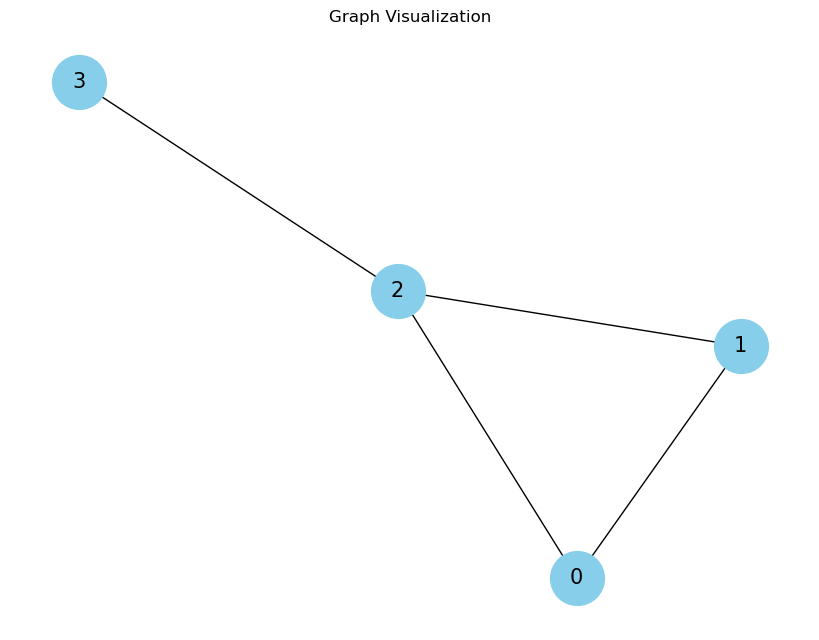

Output Features Xˆ:
[[1 2]
 [2 3]
 [4 5]
 [6 7]]
Edge Index Eˆ:
[(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1), (2, 3), (3, 2)]


In [2]:
def preprocess_features(X):
    # Calculate pairwise distances between features
    n = X.shape[0]
    pairwise_distances = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                pairwise_distances[i, j] = np.linalg.norm(X[i] - X[j])
    return pairwise_distances

def calculate_similarity(pairwise_distances):
    # Calculate similarity scores
    similarity_scores = np.exp(-pairwise_distances)
    print(similarity_scores)
    return similarity_scores

def normalize_similarity(similarity_scores):
    # Normalize similarity scores
    min_score = np.min(similarity_scores)
    max_score = np.max(similarity_scores)
    normalized_scores = (similarity_scores - min_score) / (max_score - min_score)
    return normalized_scores

def edge_formation(similarity_scores, rl):
    # Form edges based on similarity threshold rl
    n = similarity_scores.shape[0]
    edge_index = []
    for i in range(n):
        for j in range(n):
            if i != j and similarity_scores[i, j] > rl:
                edge_index.append((i, j))
    return edge_index

def output_features(X, edge_index):
    # Output features corresponding to formed edges
    output_features = set()
    for edge in edge_index:
        output_features.add(edge[0])
    return np.array([X[i] for i in output_features])

# Input features X
X = np.array([[1, 2], [2, 3], [4, 5], [6, 7]])

# Lower limit of similarity score to determine edge formation rl
rl = 0.01

# Step 1: Calculate pairwise distances between features
pairwise_distances = preprocess_features(X)

# Step 2: Calculate similarity scores
similarity_scores = calculate_similarity(pairwise_distances)

# Step 3: Normalize similarity scores
normalized_scores = normalize_similarity(similarity_scores)

# Step 4: Form edges based on similarity threshold rl
edge_index = edge_formation(normalized_scores, rl)

# Step 5: Output features corresponding to formed edges
output_features = output_features(X, edge_index)

# Create a graph
G = nx.Graph()

# Add nodes
for i in range(X.shape[0]):
    G.add_node(i)

# Add edges
for edge in edge_index:
    G.add_edge(edge[0], edge[1])

# Visualize the graph
pos = nx.spring_layout(G)  # positions for all nodes

plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='k', linewidths=1, font_size=15)
plt.title('Graph Visualization')
plt.show()

print("Output Features Xˆ:")
print(output_features)
print("Edge Index Eˆ:")
print(edge_index)

/var/folders/qt/6k9t6mfn12l30tsrj8hnl6wh0000gs/T/ipykernel_4608/3953901236.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index, dtype=torch.long)


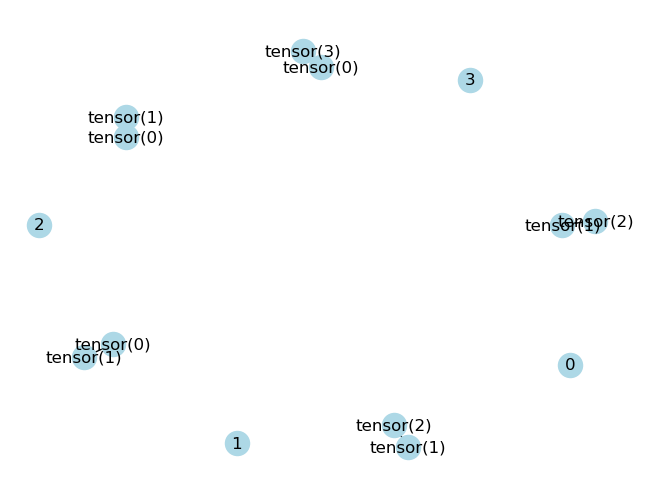

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GNNLayer(nn.Module):
    def __init__(self, input_dim, output_dim, beta):
        super(GNNLayer, self).__init__()
        self.batch_norm = nn.BatchNorm1d(input_dim)
        self.linear1 = nn.Linear(input_dim, output_dim)  # Adjusted output dimension
        self.linear2 = nn.Linear(output_dim, output_dim)
        self.beta = beta

    def forward(self, x, edge_index):
        # Batch normalization
        x = self.batch_norm(x)

        # Attention mechanism
        h_hat = self.linear1(x)
        alpha = self.calculate_attention_coefficients(h_hat, edge_index)
        
        # Aggregation step
        h_aggregated = self.aggregate_features(h_hat, alpha, edge_index)

        # Update step
        h_next = F.relu(self.linear2(h_hat) + self.linear2(h_aggregated))  # Use linear2 for consistency

        return h_next

    def calculate_attention_coefficients(self, h_hat, edge_index):
        row, col = edge_index
        # Compute the pairwise distances between node features
        pairwise_distances = torch.norm(h_hat[row] - h_hat[col], dim=1)
        # Compute the attention coefficients using the specified beta value
        alpha = torch.exp(-self.beta * pairwise_distances)
        # Normalize the attention coefficients
        alpha_normalized = alpha / torch.sum(alpha, dim=0, keepdim=True)
        return alpha_normalized

    def aggregate_features(self, h_hat, alpha, edge_index):
        row, col = edge_index
        # Aggregate neighboring node features weighted by the attention coefficients
        h_aggregated = torch.zeros_like(h_hat)
        for i in range(len(row)):
            h_aggregated[col[i]] += alpha[i] * h_hat[row[i]]
        return h_aggregated

# Example usage:
input_dim = 2  # Dimensionality of input features
output_dim = 64  # Adjusted output dimension to match linear layer
beta = 0.5  # Hyperparameter for the attention mechanism

gnn_layer = GNNLayer(input_dim, output_dim, beta)

edge_index = torch.tensor(edge_index, dtype=torch.long)

output = gnn_layer(X, edge_index)

output_list = output.tolist()

# Create a graph using NetworkX
G = nx.Graph()

# Add nodes with features to the graph
for i, features in enumerate(output_list):
    G.add_node(i, features=features)

# Add edges to the graph (assuming edge_index is available)
for edge in edge_index.T:
    G.add_edge(edge[0], edge[1])

# Visualize the graph with node features
pos = nx.spring_layout(G)  # Position nodes using Fruchterman-Reingold force-directed algorithm
nx.draw(G, pos, node_color='lightblue', with_labels=True)
plt.show()